In [110]:
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
from joblib import Parallel, delayed
sys.path.append('../')
from packages import actv_analysis, svm, load_csv

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [78]:
############# Parameters ################
relu=5;
nets=np.arange(1,11);
epochs=np.arange(0,91,10)
exps = np.arange(1,11) # SVM test trials

selectivity = 'both'
num_units = 200
congruency=np.array(['C','IC'])
#########################################
test = 37
dir_path = os.path.dirname(os.path.realpath('../'))
set_path1 = dir_path+'/dataframes/SVM/training_n_test/test'+str(test)
set_path2 = dir_path+'/dataframes/SVM/predictions/test'+str(test)
save_to_folder1 = dir_path+'/dataframes/SVM/analysis'
save_to_folder2 = dir_path+'/figures'


# Make a dataframe to store SVM performance:
num_rows = len(nets)*len(epochs)*len(congruency)
df_SVM_accuracy = pd.DataFrame(index=np.arange(num_rows), columns=['epoch','net','congruency','accuracy'])
df_SVM_accuracy.loc[:,'epoch'] = np.repeat(epochs, len(nets)*len(congruency))
df_SVM_accuracy.loc[:,'net'] = np.tile(np.repeat(np.arange(1,1+len(nets)),2), len(epochs))
df_SVM_accuracy.loc[:,'congruency'] = np.tile(congruency, len(nets)*len(epochs))


# Load all test sets for SVM and get congruent and incongruent trial indices:

all_test_X = svm.get_all_test_X(set_path1,exps)
c, ic = svm.get_congruency(all_test_X, 'dot size')

i=0
for epoch in epochs:
    #print("epoch:", epoch)
    for net in nets:
        #print("net:", net)
        all_preds = svm.get_all_preds(set_path=set_path2, net=net, relu=relu, epoch=epoch, selectivity=selectivity, num_units=num_units, exps=exps)
        acc_C = svm.get_SVM_accuracy(c, all_test_X, all_preds)
        acc_IC = svm.get_SVM_accuracy(ic, all_test_X, all_preds)
        df_SVM_accuracy.iloc[i:i+2,3] = [acc_C, acc_IC]
        i+=2
df_SVM_accuracy.to_csv(save_to_folder1+'/SVM_accuracy_test'+str(test)+'_200units.csv', index=True)

## Barplot:

* x-axis: congruency
* y-axis: accuracy

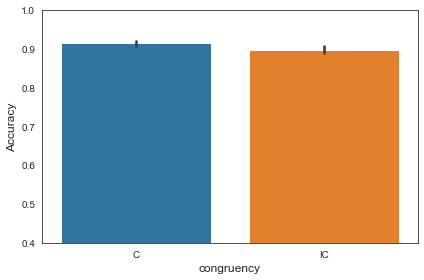

In [94]:
sns.set_style("white")
data = df_SVM_accuracy[df_SVM_accuracy['epoch']==90]

sns.barplot(data=data, x='congruency', y='accuracy')
plt.xlabel('congruency',fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.4,1)
plt.tight_layout()
plt.savefig(save_to_folder2+'/barplot congruency vs SVM accuracy'+str(test)+'test37_200units.pdf', transparent=True)

In [25]:
A = np.array([[1,2,3],[4,5,6],[7,8,9]])

In [26]:
np.random.shuffle(A.T)
A

array([[2, 3, 1],
       [5, 6, 4],
       [8, 9, 7]])

## Lineplot:

* x-axis: training epoch
* y-axis: accuracy
* hue: congruency

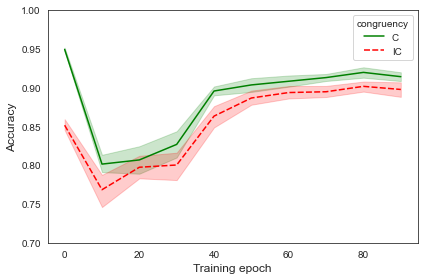

In [92]:
# Plot training epoch vs SVM performance

sns.set_style("white")
ax=sns.lineplot(data=df_SVM_accuracy, x="epoch", y="accuracy", hue="congruency", palette=['g', 'r'], style='congruency', markers=False)
plt.xlabel('Training epoch',fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.7,1)
plt.tight_layout()
plt.savefig(save_to_folder2+'/training epoch vs SVM accuracy_test'+str(test)+'_200units.pdf', transparent=True)

### number ratio vs accuracy

* x axis: number ratio
* y axis: accuracy

In [81]:
dir_path = os.path.dirname(os.path.realpath('../'))
save_to_folder = dir_path+'/dataframes/SVM/analysis'
numbers = np.arange(2,21,2)
sizes = np.arange(4,14)
test = 37; num_units = 200

# Gather all SVM test trials:
df_all_exps = pd.concat([pd.read_csv(dir_path+'/dataframes/SVM/training_n_test/test'+str(test)+'/test set idx for exp'+str(exp) + '.csv').drop(columns=['Unnamed: 0']) for exp in exps])
df_all_exps.index = np.arange(df_all_exps.shape[0])

# Make a dataframe to store all the info related to SVM:
df_all_info = pd.DataFrame(index=np.arange(df_all_exps.shape[0]*len(nets)*len(epochs)), columns=['num1', 'num2','sz1','sz2','img1','img2','net','epoch','congruency','number distance','number ratio','size distance','actv diff','correctly predicted'])
df_all_info.iloc[:,0:6] = pd.concat([df_all_exps]*len(nets)*len(epochs))

## Fill in information:

# 1. Fill in net:
df_all_info.loc[:,'net'] = np.tile(np.repeat(np.arange(1,len(nets)+1), df_all_exps.shape[0]), len(epochs))
# Fill in epoch:
df_all_info.loc[:,'epoch'] = np.repeat(epochs, df_all_exps.shape[0]*len(nets))
# 2. Fill in congruency:
exp_idx = np.arange(df_all_info.shape[0])
c1 = exp_idx[((df_all_info.loc[:,'num1'] < df_all_info.loc[:,'num2'])&(df_all_info.loc[:,'sz1'] < df_all_info.loc[:,'sz2']))]
c2 = exp_idx[((df_all_info.loc[:,'num1'] > df_all_info.loc[:,'num2'])&(df_all_info.loc[:,'sz1'] > df_all_info.loc[:,'sz2']))]
c = np.union1d(c1,c2)
ic = np.setdiff1d(exp_idx, c)
df_all_info.loc[c,'congruency'] = 'C'
df_all_info.loc[ic,'congruency'] = 'IC'
# 3. Fill in number and size distance:
df_all_info.loc[c,'number distance'] = -np.abs(numbers[df_all_info.loc[c,'num1'].to_numpy().astype(int)] - numbers[df_all_info.loc[c,'num2'].to_numpy().astype(int)])
df_all_info.loc[ic,'number distance'] = np.abs(numbers[df_all_info.loc[ic,'num1'].to_numpy().astype(int)] - numbers[df_all_info.loc[ic,'num2'].to_numpy().astype(int)])
df_all_info.loc[c,'size distance'] = -np.abs(df_all_info.loc[c,'sz1']-df_all_info.loc[c,'sz2'])
df_all_info.loc[ic,'size distance'] = np.abs(df_all_info.loc[ic,'sz1']-df_all_info.loc[ic,'sz2'])
# 4. Fill in number ratio:
df_all_info.loc[:,'number ratio'] = numbers[np.amin(df_all_info.iloc[:,0:2].to_numpy(), axis=1).astype(int)]/numbers[np.amax(df_all_info.iloc[:,0:2].to_numpy(), axis=1).astype(int)]
# 5. Fill in prediction:
all_y = svm.get_y(df_all_exps).to_numpy()

# 6. Fill in prediction accuracy:
for epoch in epochs:
    for net in nets:
        file = '/SVM prediction of He untrained net'+str(net)+' relu'+str(relu)+' epoch'+str(epoch)+' '+str(num_units)+ ' '+selectivity+' units that are randomly drawn from distribution '
        net_idx = df_all_info[(df_all_info['epoch']==epoch)&(df_all_info['net']==net)].index.to_numpy()
        df_all_preds = pd.concat([pd.read_csv(dir_path+'/dataframes/SVM/predictions/test'+str(test)+file+'exp'+str(exp)+ '.csv').drop(columns=['Unnamed: 0']) for exp in exps])
        correct_or_not = all_y == df_all_preds.iloc[:,0].to_numpy()
        df_all_info.loc[net_idx,'correctly predicted'] = correct_or_not
df_all_info.to_csv(save_to_folder+'/SVM all info test'+str(test)+' 200 units.csv', index=True)

/var/folders/yq/vnn1qzt56k7041vctbsfrxj40000gn/T/ipykernel_19972/2190658303.py:18: RuntimeWarning: invalid value encountered in long_scalars
  df_numratio_vs_acc.loc[item, 'inaccuracy'] = (_data.shape[0] - np.sum(_data['correctly predicted']))/_data.shape[0]


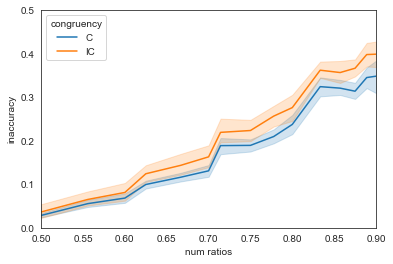

In [91]:
save_to_folder = dir_path+'/figures'

# Load data:
data = pd.read_csv(dir_path+'/dataframes/SVM/analysis/SVM all info test'+str(test)+' 200 units.csv').drop(columns=['Unnamed: 0'])
num_ratios = np.unique(data['number ratio'].to_numpy())
data = data[data['epoch']==10]

# Make a dataframe for the plot:
df_numratio_vs_acc = pd.DataFrame(index=np.arange(len(nets)*len(epochs)*len(num_ratios)*len(congruency)), columns= ['net', 'network', 'num ratios', 'congruency','inaccuracy'])
df_numratio_vs_acc.loc[:,'net'] = np.tile(np.repeat(nets, len(congruency)*len(num_ratios)), len(epochs))
df_numratio_vs_acc.loc[:,'epoch'] = np.repeat(epochs, len(nets)*len(congruency)*len(num_ratios))
df_numratio_vs_acc.loc[:,'num ratios'] = np.tile(num_ratios, len(nets)*len(epochs)*len(congruency))
df_numratio_vs_acc.loc[:,'congruency'] = np.tile(np.repeat(np.array(['C','IC']),len(num_ratios)),len(nets)*len(epochs))

# Simple sorting and add relevant results for plotting to the dataframe:
for item in np.arange(df_numratio_vs_acc.shape[0]):
    _data = data[(data['net']==df_numratio_vs_acc.loc[item, 'net'])*(data['epoch']==df_numratio_vs_acc.loc[item, 'epoch'])*(data['number ratio']==df_numratio_vs_acc.loc[item, 'num ratios'])*(data['congruency']==df_numratio_vs_acc.loc[item, 'congruency'])]
    df_numratio_vs_acc.loc[item, 'inaccuracy'] = (_data.shape[0] - np.sum(_data['correctly predicted']))/_data.shape[0]

# Plot a lineplot:
# x-axis = number ratio (smaller/larger number)
# y-axis = SVM performance (in terms of inaccuracy)
sns.set_style('white')
sns.lineplot(data = df_numratio_vs_acc, x='num ratios', y='inaccuracy', hue='congruency')
plt.xlim(0.5,0.9); plt.ylim(0,0.5)
plt.savefig(save_to_folder+"/lineplot for number ratios vs number comparison inaccuracy test37 epoch10 200units.pdf", transparent=True)

In [41]:
### number ratio vs accuracy

x axis: number ratio
y axis: accuracy

array([20, 20, 16, ..., 20, 18, 16])

In [108]:
nets = np.arange(1,11)
epochs = np.arange(0,91,10)
df_congruency = pd.DataFrame(index=np.arange(len(nets)*len(epochs)), columns=['epoch','net','congruency effect'])
df_congruency.loc[:,'epoch'] = np.repeat(epochs, len(nets))
df_congruency.loc[:,'net'] = np.tile(nets, len(epochs))
df_congruency.loc[:,'congruency effect'] = df_SVM_accuracy[::2]['accuracy'].to_numpy() - df_SVM_accuracy[1::2]['accuracy'].to_numpy()

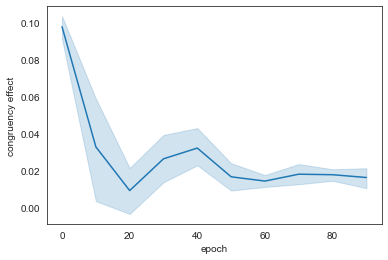

In [109]:
sns.lineplot(data = df_congruency, x='epoch', y='congruency effect')
plt.savefig(save_to_folder+"/lineplot for epoch vs congruency effect test37 200units.pdf", transparent=True)

In [112]:
df_SVM_accuracy
#scipy.stats.wilcoxon(x, y=None

,epoch,net,congruency,accuracy
0,0,1,C,0.951825
1,0,1,IC,0.878899
2,0,2,C,0.945198
3,0,2,IC,0.85006
4,0,3,C,0.944643
...,...,...,...,...
195,90,8,IC,0.889256
196,90,9,C,0.918373
197,90,9,IC,0.896012
198,90,10,C,0.901667


In [121]:
scipy.stats.wilcoxon(x = df_congruency[df_congruency['epoch']==30]['congruency effect'], y = df_congruency[df_congruency['epoch']==90]['congruency effect'])

WilcoxonResult(statistic=15.0, pvalue=0.232421875)